# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 3: Analysis Choices in Sea-Level Modelling (15-20 minutes)
This tutorial about analysis choice includes some relatively advanced content which assumes some basic knowledge about statistics. Although understanding this tutorial will be helpful for better using PaleoSTeHM, it is `not necessary` for everyone to understand the content here about optimization as PaleoSTeHM will provide automatic tool to do that for you.

### Deterministic vs Probablisitic

Analysis choice decisions in how to implement a specific model structure. Generally, we can think a model either to be a deterministic model or a probabilistic (i.e., stochastic) model. And for each type of these model, we apply different analysis choices. 

For a [deterministic method](https://en.wikipedia.org/wiki/Deterministic_algorithm), it assumes given a particular input, this model will always produce the same output, with the underlying machine always passing through the same sequence of states. Typical examples of this type of model include ordinary linear regression, Poisson Regression, ARIMA (AutoRegressive Integrated Moving Average) and neural network.

Alternatively, a [probabilistic model](https://en.wikipedia.org/wiki/Probabilistic_method) presents data and predicts outcomes that account for certain levels of unpredictability or randomness, which are often represented by probablisitic density functions (PDF). Typical examples of this type of model include Bayesian linear regression, Bayesian nerual network and Gaussian Process. 

### 1. Deterministic model analysis choice

#### 1.1 Least Squares
For deterministic models, there are multiple analysis choices to find a set of parameters that best fit the observation. For models with relatively small to medium amount of parameters (say <1000 parameters), least squares family methods, that minimize the sum of the squared differences between the observed data and the predicted values from the model, is commonly-used. 

Depending on the observational errors, three commonly-used least squares methods are: (1) ordinary least squares (OLS); (2) weighted least squares (WLS) and (3) generalized least squares (GLS). OLS analysis does not include implementation of a data level, and therefore typically excludes explicit measurement and inferential uncertainties. It also assumes errors are independent and identically distributed. 

WLS and GLS are slightly more advanced solutions than OLS, where WLS addresses the problem of heteroscedastic (unequal) variances, and GLS additionally addresses the problem of autocorrelation among variances, both of which are common characteristics of data used in sea-level analyses. In other words, heteroscedastic address the problem that the data quality of some observations maybe better than ohters, hence, least squares will pay more attentions to fit those high-qualtiy data than other low-quality data. The autocorrelation among variances indicate the uncertainties between different data points might correlate with each other, which can be a case for data points from the same sediment core. 

Let's try them out below using sea-level data from Norhtern North Carolina by [Kemp et al., 2011](https://www.pnas.org/doi/abs/10.1073/pnas.1015619108). We will use a linear model:
$$
y_{i} = at_{i} +b + \epsilon_{i}\\
\epsilon_{i} \sim N(0,\sigma_{\epsilon_{i}})\\
\overline{t}_{i} = t_{i} + \delta{i}\\
\delta_{i} \sim N(0,\sigma_{\delta_{i}})
$$
where a and b are objective parameters for optimization, $\epsilon_{i}$ indicates RSL vertical reconstruction uncertainty and $\delta{i}$ denotes geochronological uncertainties. For deterministic method, we will optimize a single value $\hat{a}$ and $\hat{b}$.  

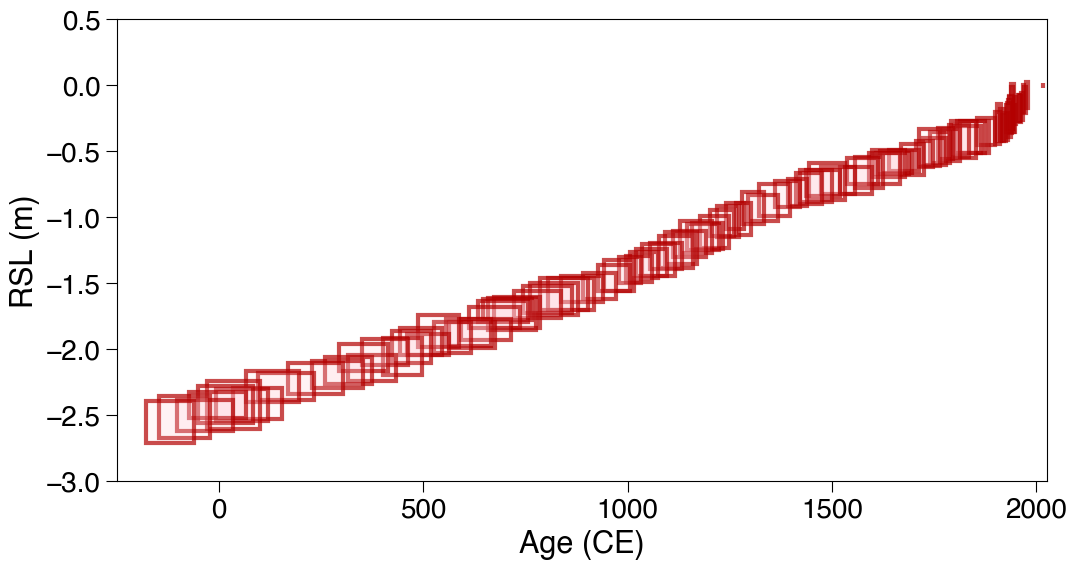

In [2]:
import sys
import time
sys.path.append('../..')
import PSTHM 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
from scipy import interpolate
import pyro.contrib.gp as gp
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS 
warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

#load data 
NNC_X,NNC_y,NNC_y_sigma,NNC_x_sigma,NNC_lon,NNC_lat = PSTHM.load.load_local_rsl_data('../../Data/NNC_CC.csv')

#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,CE=True)
ax.set_xlim(-250,2025)
ax.set_ylim(-3,0.5)
plt.show();

OLS sea-level intercept: -2527.346 (mm), sea-level rise rate 1.180 (mm/yr)
WLS sea-level intercept: -2576.616 (mm), sea-level rise rate 1.235 (mm/yr)
GLS sea-level intercept: -2576.616 (mm), sea-level rise rate 1.235 (mm/yr)


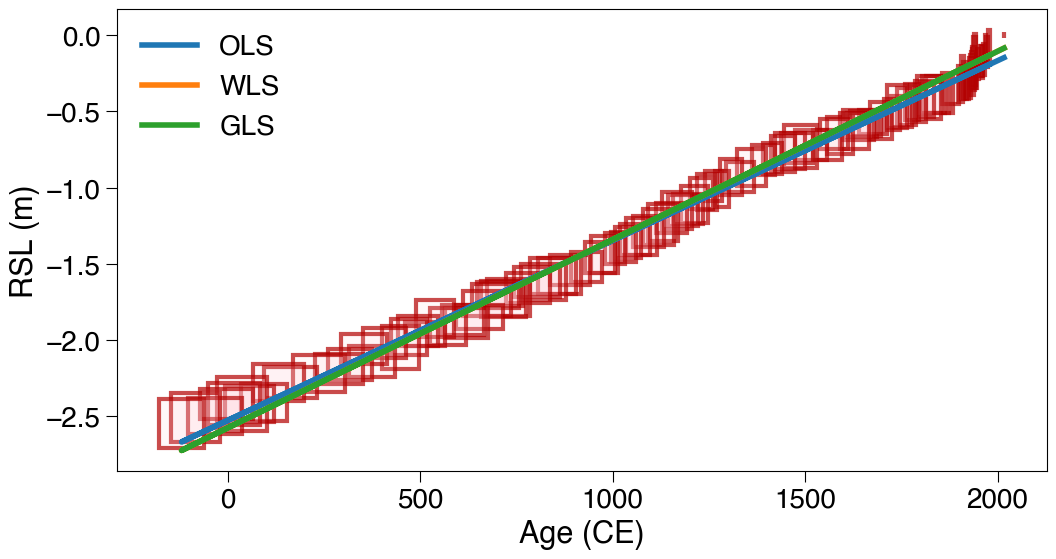

In [3]:
import statsmodels.api as sm
#-----OLS Regression-----
# OLS
X_ols = sm.add_constant(NNC_X)
model_ols = sm.OLS(NNC_y.numpy(), X_ols)
results_ols = model_ols.fit()
print('OLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_ols.params *1000))

#-----WLS Regression-----
weights = 1/NNC_y_sigma**2 #where we only consider vertical uncertainty 
model_wls = sm.WLS(NNC_y.numpy(), X_ols, weights=weights)
results_wls = model_wls.fit()
print('WLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_wls.params *1000))


#-----GLS Regression-----

cov_struct = np.diag(NNC_y_sigma**2)
model_gls = sm.GLS(NNC_y.numpy(), X_ols, sigma=cov_struct)
results_gls = model_gls.fit()
print('GLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_gls.params *1000))

#Visualize the results
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,CE=True)

ax.plot(NNC_X,results_ols.predict(X_ols),label='OLS',lw=4)
ax.plot(NNC_X,results_wls.predict(X_ols),label='WLS',lw=4)
ax.plot(NNC_X,results_gls.predict(X_ols),label='GLS',lw=4)
plt.legend();

 You may find WLS and GLS yields the same results here, this is because we assume the data uncertainty here are independent, meaning uncertainties for different data points being unrelated or not influencing each other in any way. This assumption may not stand to some cases of paleo sea-level data, such as when observational ages are from age-depth modelling of radiocarbon dating. In that case, the age uncertainties of each data point will not be independent. Hence, instead of putting a diagnal covariance matrix (cov_struct variable in the code above; $ \Omega$) like: 

 $$
  \Omega = \begin{pmatrix}
  \sigma y_{1} ^2      & 0     & \cdots  & 0  \\
  0       &   \sigma y_{2}^2      & \cdots  & 0 \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  0       & 0     & \cdots  & \sigma y_{n}^2  \\
\end{pmatrix}
$$
we should calculate the covariance between uncertainty model from each data point:

 $$
  \Omega =\begin{pmatrix}
  \sigma y_{1}^2       & cov(\sigma y_{1} ,\sigma y_{2} )     & \cdots  & cov(\sigma y_{1} ,\sigma y_{n} )  \\
cov(\sigma y_{1} ,\sigma y_{2} )       &   \sigma y_{2} ^2     & \cdots  & cov(\sigma y_{2} ,\sigma y_{n} ) \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  cov(\sigma y_{1} ,\sigma y_{n} )       & cov(\sigma y_{2} ,\sigma y_{n} )    & \cdots  & \sigma y_{n} ^2 \\
\end{pmatrix}
$$

By doing this, GLS will be able to capture the potential correlation between observational uncertainties.

#### 1.2 Gradient-based optimization

For deterministic models with largr amount of parameters, it can be very slow to perform least squares method due to the large computational resources required to perform matrix operations such as matrix inversion, matrix multiplication. Unlike least square that provides an exact solution of model paramters, gradient-based optimization iteratively update the model parameters to minimize a specified loss function (or cost function), which provides a measure of the model goodness of fit to the data. It starts with an initial guess for the parameter values and iteratively adjusts them based on the gradient from loss function, until converge, each is often regarded as the `learning` process in machine learning field. Note, in machine learning field, `weight` indicates parameter values. 

<img width=800px src="GD.png"/>

To illustrate, let's try to estimate the linear sea-level rise rate in Northern North Carolina that accounts for heteroscedastic (i.e., equivalent to WLS). In this case, the loss function is:
$$
loss = \frac{1}{N} \sum_{i=1}^{N}(\frac{y_{i}-\hat{y_{i}}}{\sigma y_{i}})^2
$$
Let's see how can we do it in Pytorch, a fundamental building block for PaleoSTeHM. 


Sea-level rise rate by gradient-based optimization: 1.235 (mm/yr)


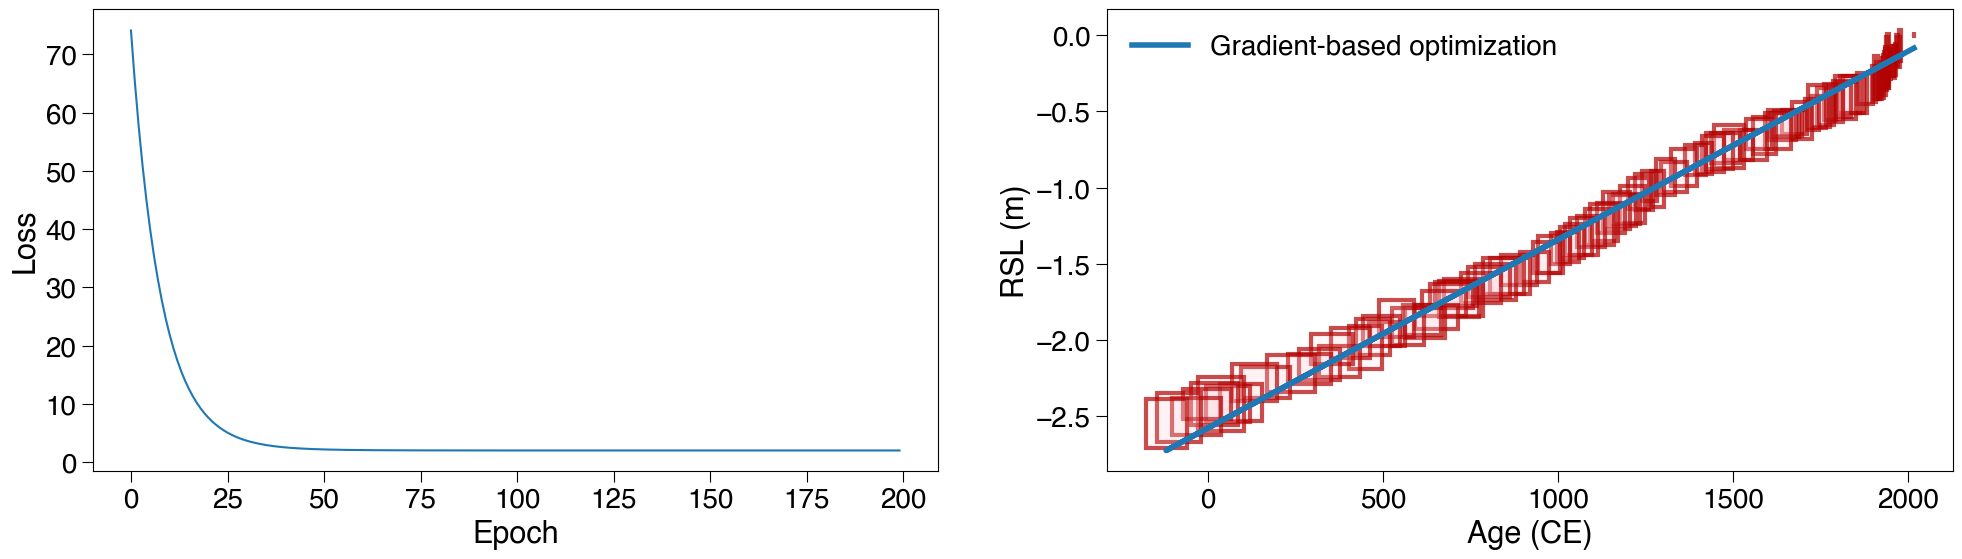

In [3]:
import torch.nn as nn

# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_dim = 1  # Number of input features (independent variables)
output_dim = 1  # Number of output features (dependent variable)
model = LinearRegression(input_dim, output_dim)

# Define loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)  # Stochastic Gradient Descent optimizer
#normalize the data and the uncertainty
X_norm = (NNC_X.float() - NNC_X.float().mean()) / NNC_X.float().std()
y_norm = (NNC_y.float() - NNC_y.float().mean()) / NNC_y.float().std()
y_sigma_norm = (NNC_y_sigma.float() ) / NNC_y.float().std()
losses = []
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_norm[:,None])

    # Compute loss function
    loss =(((y_pred-y_norm[:,None])/y_sigma_norm[:,None])**2).sum()/len(y_norm)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    losses.append(loss.item())
    
#calculate the sea-level rise rate
w = model.linear.weight.item()
b = model.linear.bias.item()
y_pred = w * X_norm + b
test_y = (y_pred *NNC_y.float().std() +NNC_y.mean()).detach().numpy()
output_rate = (test_y[2]-test_y[1])/(NNC_X[2]-NNC_X[1])*1000
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
print('Sea-level rise rate by gradient-based optimization: {:3.3f} (mm/yr)'.format(output_rate))
ax = plt.subplot(1,2,2)
PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,CE=True,ax=ax)
ax.plot(NNC_X,test_y,label='Gradient-based optimization',lw=4)
plt.legend();

After 1000 epoches of learning, you can find that we got pretty much the same result of sea-level rise rate as WLS, indicating the gradient-based results converge well to find the minimum of loss function. Overall, the choice between least squares and gradient-based optimization depends on specific problem, dataset size, computational resources, and the desired trade-off between accuracy and scalability. Least squares provides an exact solution but may be less scalable and sensitive to outliers. Gradient descent offers more flexibility and scalability but requires tuning of hyperparameters and convergence criteria. You can check [this blog](https://towardsdatascience.com/https-medium-com-chayankathuria-optimization-ordinary-least-squares-gradient-descent-from-scratch-8b48151ba756) to learn more about the pros and cons for them.

To make sure that the gradient-based optimization approach converge to a global minimum location, we need to see it decreases from the initial loss for some epoches before reaching to a minimum loss. To achieve this, selecting a good learning rate, a hyperparameter governs the pace at which an algorithm updates or learns the values of a parameter estimate, is important. You can see different learning rate impact on loss function here:

<img width=500px src="lr.png"/>


If you have gone through our previous tutorials, you should be familiar with the loss function, so you might have a question, why we can get probabilistic estimates of sea-level rise rate with gradient-based optimization in the last tutorial? Isn't it designed for deterministic method? The reason for that is we have used the variational Bayesian method in previous examples, you can check out more details below.



### 2. Probabilistic model analysis choice

There are many probabilistic methods, one popular-choice among them which we will cover here is Bayesian inference that uses Bayes theorem to invert the conditional probability of the observed data and calculate the conditional probability of unknown parameter(s) or process(es). This has been covered in the introduction tutorial. Here we focus on how to infer posterior distribution of unknown parameter(s) and process(es). 
#### 2.1 Fully Bayesian Analysis
In Bayesian inference, the poterior distributions are controlled by prior distribution and likelihood, which often result in a complex posterior distribution that cannot be directly calculated or sampled from using analytical methods (i.e., intractable). In this case, we need to use Markov Chain Monte Carlo (MCMC) to enables us to explore and approximate the posterior distribution. This is the so-called fully Bayesian analysis, which can be easily implemented in pyro framework by:

**&#10148; 1.** Define process model

**&#10148; 2.** Define prior distributions for process level model parameters

**&#10148; 3.** Define prior distributions for data level model parameters

**&#10148; 4.** Perform MCMC

Specifically, we will use the No-U Turn Sampler ([NUTS](https://arxiv.org/abs/1111.4246)), which provides an efficient and automated way of running Hamiltonian Monte Carlo. Compared to traditional [metropolis-hastings MCMC](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), Hamiltonian Monte Carlo (HMC) based methods are much more efficient in getting samples with lower autocorrelations. This means that, the effective sample size for HMC is usually much higher than the metropolis-hastings MCMC when they have the same number of iterations. For example, with Gibbs sampling (a specific type of metropolis-hastings method) researchers usually need 50,000 or 100,000 iterations, whereas with STAN something around 1000-2000 would be enough for regression models. You might want to check [this animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) of how these two types of MCMC work to sample a banana-shaped posterior distribution.

In [4]:
#------Define process model------
#note this is the same linear model as in PSTHM.model but without x uncertainty

def linear_model(X, y,y_sigma,intercept_prior,coefficient_prior):
    '''
    A function to define a linear model in pyro 

    ------------Inputs--------------
    X: 2D torch tensor with shape (n_samples,n_features)
    y: 1D torch tensor with shape (n_samples)
    x_sigma: float, standard deviation of the error for age, which is obtained from the age data model
    y_sigma: float, standard deviation of the error for the RSL, which is obtained from the RSL datamodel
    intercept_prior: pyro distribution for the intercept coefficient
    coefficient_prior: pyro distribution for the slope coefficient

    '''
    # Define our intercept prior
    
    linear_combination = pyro.sample("b", intercept_prior)
    #Define our coefficient prior
    
    beta_coef = pyro.sample("a", coefficient_prior)
    #generate random error for age

    
    #calculate mean prediction
    mean = linear_combination + ( X * beta_coef)
    with pyro.plate("data", y.shape[0]):        
        # Condition the expected mean on the observed target y
        #define data level model
        observation = pyro.sample("obs", dist.Normal(mean, y_sigma), obs=y)

In [23]:
torch.manual_seed(30)

st = time.time() 

pyro.clear_param_store()
#------Define the process mdoel---------
model = linear_model
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 0.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Run MCMC---------

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=7000, warmup_steps=500)
mcmc.run(NNC_X,NNC_y,NNC_y_sigma,intercept_prior,coefficient_prior)
#-------get posterior samples---------
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
for name, value in hmc_samples.items():
    print('-----{}: {:4.7f} +/-  {:4.7f} (2sd)-----'.format(name,value.mean(),2*value.std()))
    print('Gelman-Rubin statistic for {}: {:4.2f}'.format(name,mcmc.diagnostics()[name]['r_hat'].item()))
    print('Effective sample size for {}: {:4.2f}'.format(name,mcmc.diagnostics()[name]['n_eff'].item()))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

Sample: 100%|██████████| 7500/7500 [00:33, 226.52it/s, step size=1.24e-01, acc. prob=0.919]


-----a: 0.0012350 +/-  0.0000144 (2sd)-----
Gelman-Rubin statistic for a: 1.00
Effective sample size for a: 1305.86
-----b: -2.5768360 +/-  0.0216931 (2sd)-----
Gelman-Rubin statistic for b: 1.00
Effective sample size for b: 1162.04
Execution time: 33.303 s


After several minutes of computation, we now have the posterior distributions of two hyperparameters for the RBF kernel. It should be noted that, when working with any MCMC based approach, we should check two metrics to ensure the MCMC results are ready for further analysis: (1) convergence status; (2) effective sample size.

`1. Convergence:` For MCMC, t is crucial to ensure that the Markov Chains have reached the stationary stage, indicating a good convergence stage and it can accurately represent the posterior distribution. One commonly used approach for assessing convergence is the Gelman-Rubin statistic. This statistical measure analyzes the differences between multiple Markov chains to evaluate convergence. 

The Gelman-Rubin statistic assesses convergence by comparing the estimated between-chains and within-chain variances for each model parameter. Typically, a Gelman-Rubin statistic of less than 1.1 indicates good convergence, denoting that the Markov Chains have adequately explored the posterior distribution. We can see our Gelman-Rubin stats are both below 1.1 above, hence, the hyperparameters aboved should be converged. 

`2. Effective sample size:` [effective sample size](https://andrewcharlesjones.github.io/journal/21-effective-sample-size.html#:~:text=The%20effective%20sample%20size%20is,and%20redundancy%20between%20the%20samples.) is a metric that measures how much information content is loss due to the correlation in the sequence. It therefore measures the information content, or effectiveness of a sample chain. Usually, an effective sample size greater than 1,000 is sufficient for stable estimates ([Bürkner, 2017](https://www.jstatsoft.org/article/view/v080i01)). 

We can see our Gelman-Rubin stats are both below 1.1 above, and the effective sample size are more than 1,000, so we are good to go! Let's check the posterior distributions of our model parameters and latent process (sea-level change). 

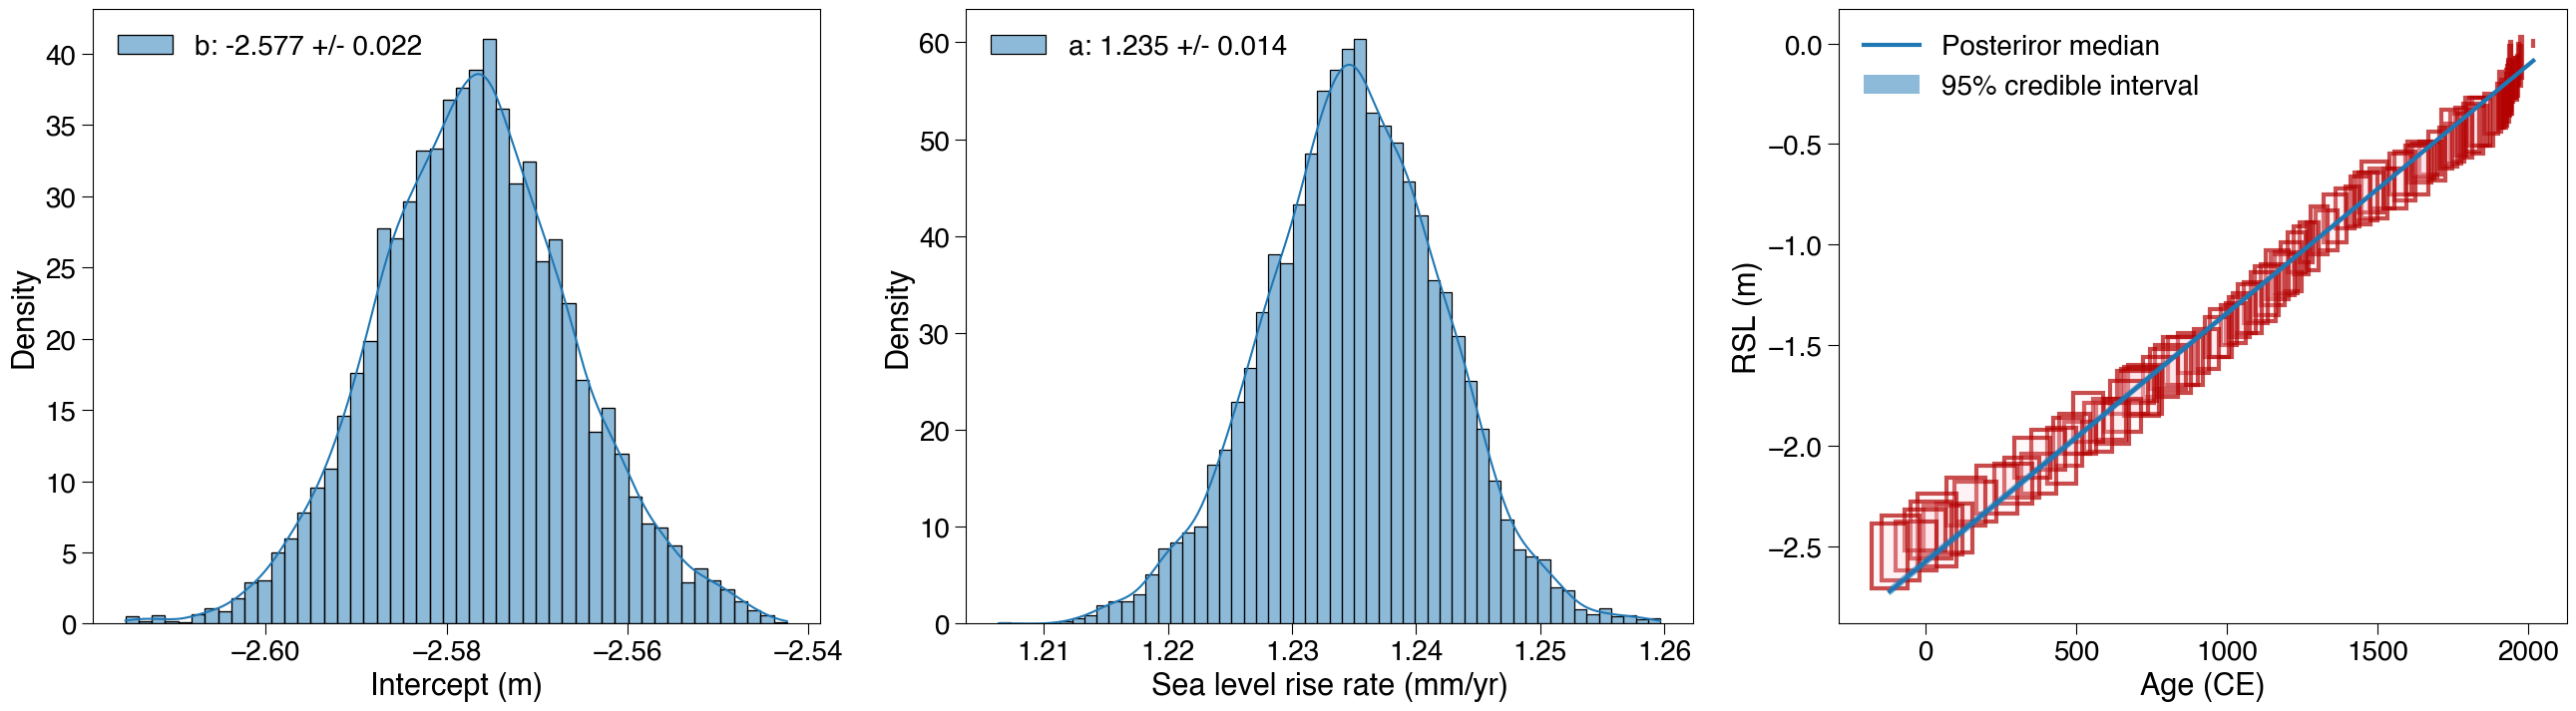

In [24]:
#-------plot the posterior distribution---------
fig = plt.figure(figsize=(32, 8))
ax1 = plt.subplot(131)
sns.histplot(hmc_samples['b'], ax=ax1,label='b: {:4.3f} +/- {:4.3f}'.format(hmc_samples['b'].mean(),2*hmc_samples['b'].std()),
             kde=True, stat='density')
plt.xlabel('Intercept (m)')
plt.legend()

ax2 = plt.subplot(132)
sns.histplot(hmc_samples['a']*1000, ax=ax2,label='a: {:4.3f} +/- {:4.3f}'.format(hmc_samples['a'].mean()*1000,2*hmc_samples['a'].std()*1000),
             kde=True, stat='density')
plt.xlabel('Sea level rise rate (mm/yr)')
plt.legend()

ax3 = plt.subplot(133)
PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax3,CE=True)
posterior_pred = np.zeros([len(hmc_samples['b']),2])
forward_x = np.array([NNC_X.min(),NNC_X.max()])
for i in range(len(hmc_samples['b'])):
    forward_y = hmc_samples['b'][i] + forward_x * hmc_samples['a'][i]
    posterior_pred[i] = forward_y
posterior_2p5,posterior_50,posterior_97p5 = np.percentile(posterior_pred,[2.5,50,97.5],axis=0)
ax3.plot(forward_x,posterior_50,lw=3,label='Posteriror median')
ax3.fill_between(forward_x,posterior_2p5,posterior_97p5,alpha=0.5,label='95% credible interval')
plt.legend();

Now, you can see that, instead of a single estimate, we have posterior distributions of model parameter and latent process which can be used to probablistic analysis. 

#### 2.2 Variational Bayes Methods
A prominent problem of MCMC is the computational resources required by it, with more complicated process model and observational data, it can easily takes several days to complete. A popular way to mitigate this is [variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), which allow us to re-write statistical inference problems (i.e. infer the value of a random variable given the value of another random variable) as optimization problems (i.e. find the parameter values that minimize some objective function). That's why we use loss function to check our model performance, instead of MCMC stats we shown above, in the last two tutorials!

In variational inference, the goal is to approximate the true posterior distribution by finding the "closest" distribution from a simpler family of distributions. In this figure below, we can see $P(Z|X)$ is the true posterior distribution we want to sample and $Q(Z)$ is a normal distribution we can easily sample from. The goal here is therefore to adjust the parameters of $Q$ parameters so that $Q(Z)$ is as close to $P$ as possible. We won't cover too much details about it here, you can check [this blog by Eric Jang](https://blog.evjang.com/2016/08/variational-bayes.html) for more details about variational method.
  
<img width=500px src="VI.png"/>

In pyro, the $Q$ distribution is referred as `guide`, which can be easily optimized to fit the posterior distribution by Stochastic Variational Inference (SVI) method, which extends variational inference by introducing [stochastic optimization techniques](https://en.wikipedia.org/wiki/Stochastic_optimization), making it more scalable and efficient for large-scale problems. Let's try it using the same linear model above, assuming model parameters $a$ and $b$ are from multivariate normal distribution:

Execution time: 2.680 s


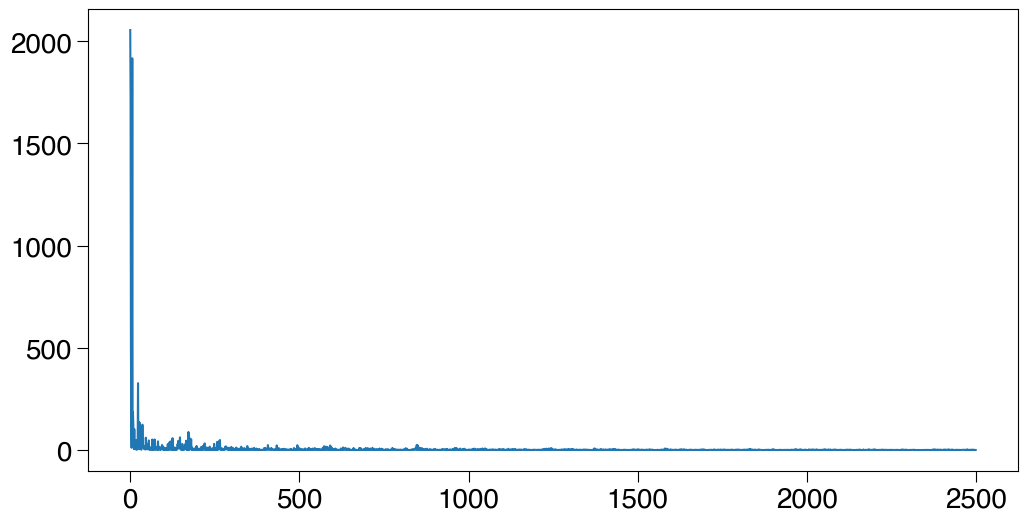

In [25]:
torch.manual_seed(30)

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO
st = time.time() 
pyro.set_rng_seed(12345)
model = linear_model
#define the guide to be multivariate normal
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 0.)
coefficient_prior = dist.Uniform(-0.01,0.01)

#-------Train the model---------
pyro.clear_param_store()
losses = []
adam = pyro.optim.Adam({"lr":0.075})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
for j in range(2500):
    # calculate the loss and take a gradient step
    loss = svi.step(NNC_X,NNC_y,NNC_y_sigma,intercept_prior,coefficient_prior)
    losses.append(loss/len(NNC_X))

plt.plot(losses)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


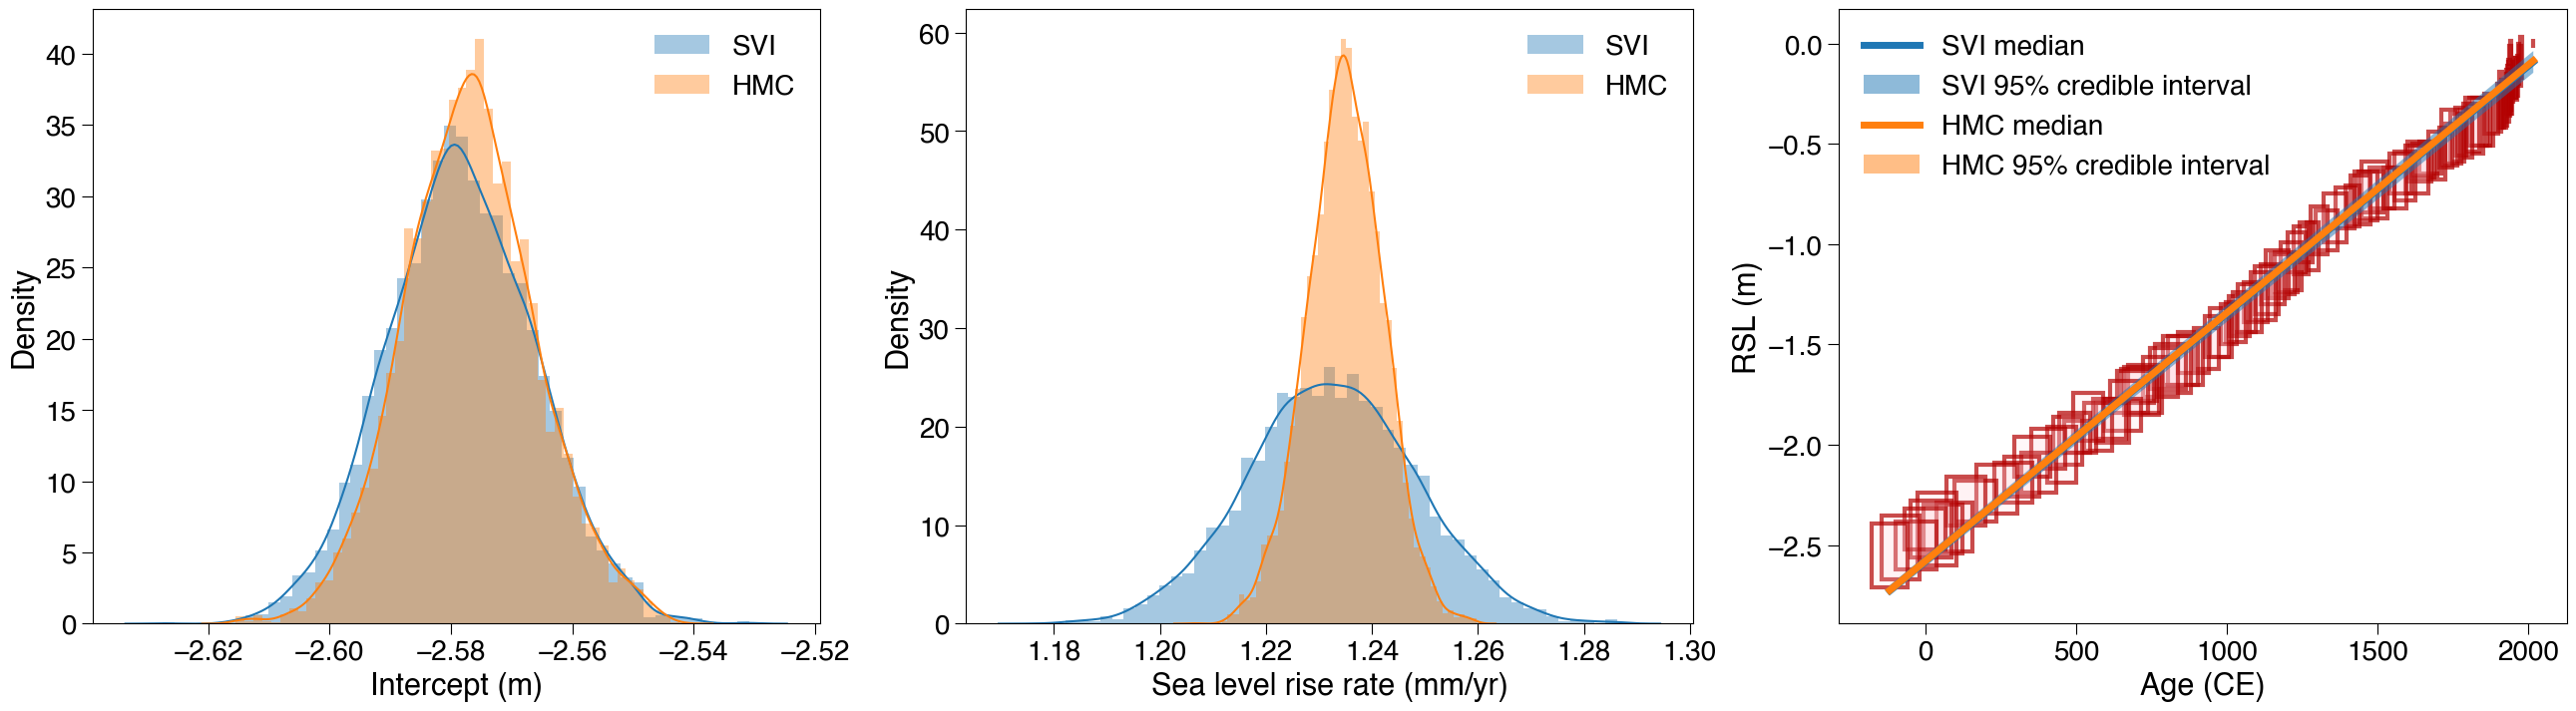

In [26]:
#-------get posterior samples---------
forward_x = np.array([NNC_X.min(),NNC_X.max()])
SVI_a,SVI_b,SVI_pred = np.zeros(7000),np.zeros(7000),np.zeros([7000,2])

for i in range(7000):
    SVI_sample = guide()
    SVI_a[i] = SVI_sample['a'].detach().cpu().numpy()
    SVI_b[i] = SVI_sample['b'].detach().cpu().numpy()
    SVI_pred[i] = SVI_b[i] + forward_x * SVI_a[i]

#-------plot the posterior distribution---------
fig = plt.figure(figsize=(32, 8))
ax1 = plt.subplot(131)
sns.distplot(SVI_b, ax=ax1,label='SVI')
sns.distplot(hmc_samples['b'], ax=ax1,label='HMC')


plt.xlabel('Intercept (m)')
plt.legend()

ax2 = plt.subplot(132)
sns.distplot(SVI_a*1000, ax=ax2,label='SVI')
sns.distplot(hmc_samples['a']*1000, ax=ax2,label='HMC')
plt.xlabel('Sea level rise rate (mm/yr)')
plt.legend()

ax3 = plt.subplot(133)
PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax3,CE=True)
SVI_2p5,SVI_50,SVI_97p5 = np.percentile(SVI_pred,[2.5,50,97.5],axis=0)
plt.plot(forward_x,SVI_50,lw=5,label='SVI median')
plt.fill_between(forward_x,SVI_2p5,SVI_97p5,alpha=0.5,label='SVI 95% credible interval')
ax3.plot(forward_x,posterior_50,lw=5,label='HMC median')
ax3.fill_between(forward_x,posterior_2p5,posterior_97p5,alpha=0.5,label='HMC 95% credible interval')
plt.legend();

The can see that the guide by SVI method generate a decent representation of the 'true' posterior results created by MCMC but with much less computational time. Now you see the pros and cons of MCMC and SVI methods, you can decide which method to implement based on your own problem.

#### 2.3 Empirical Bayesian Analysis
For modelling sea-level change, other than fully Bayesian method, another popular analysis choice is Empirical Bayesian Analysis. It may be viewed as an approximation to a fully Bayesian treatment of a hierarchical model wherein the parameters at the highest level of the hierarchy are set to their most likely values, instead of being integrated out, the most likely values are often optimized using maximum likelihood estimate (MLE), meaning this method yields a posterior distribution conditional on the data and the optimal parameters:
$$
p(f|y,\hat{\theta_{s}},\hat{\theta_{d}}) \propto p(y | f,\hat{\theta_{d}}) p(f|\hat{\theta_{s}})
$$
In this expression, we only infer the posterior probability of latend processes ($f$), assuming the data level and process level parameters are known. Although explicit bounds are usually set on hyperparameters for MLE, there is no explicit prior distribution on the parameters. The reason why Empirical Bayesian Analysis is usefully is that it is computatioanlly much cheaper compared with Fully Bayesian method, although the uncertainty estimate from it can be less thorough. 

Let's try empirical and fully Bayesian analysis now with a Gaussian Process model, a popular process model we have introduced in the last tutorial. We will demonstrate it using PaeloSTeHM module. 

**Empirical Bayesian Analysis:**

  0%|          | 0/500 [00:00<?, ?it/s]

Execution time: 0.968 s


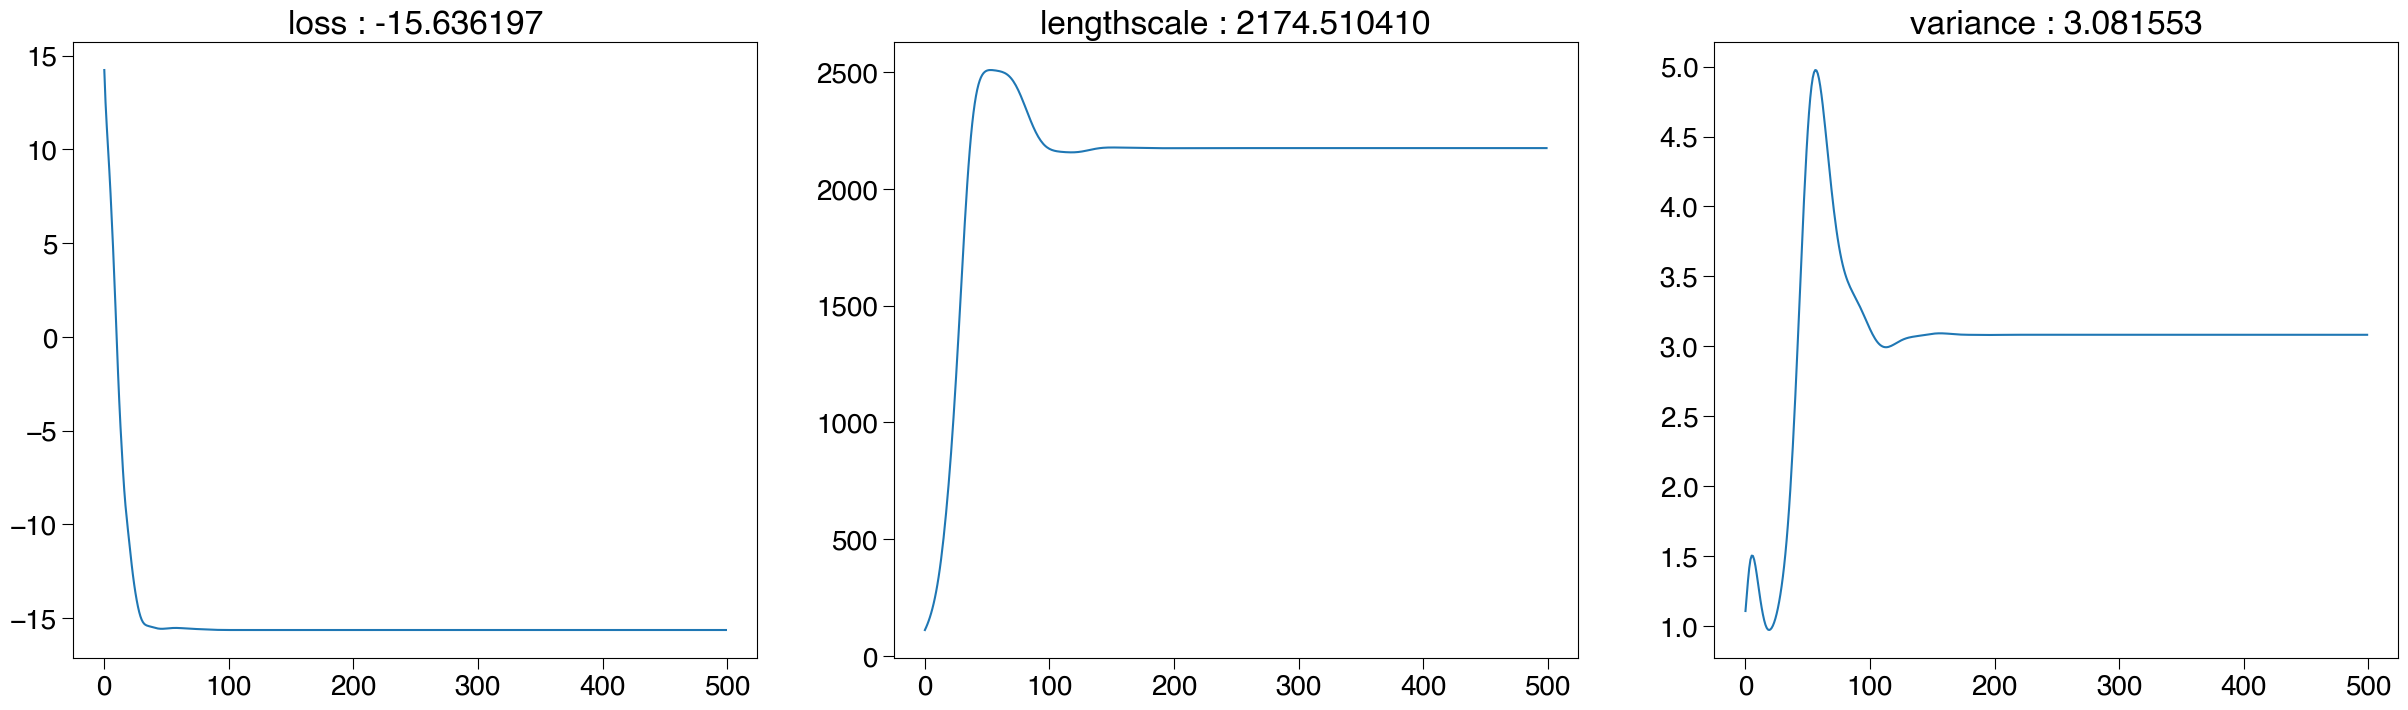

In [122]:
np.random.seed(100)
random_index = np.random.randint(0,len(NNC_X),int(len(NNC_X)*0.15))

#------------------Empirical Bayes------------------
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(100.),geo=False)

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(NNC_X[random_index], NNC_y[random_index], RBF_kernel,noise=torch.tensor(NNC_y_sigma[random_index]**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 500
gpr,emp_track_list = PSTHM.opti.SVI_NI_optm(gpr,NNC_x_sigma[random_index],num_iteration=500)
#Plot the optimization track 
axes = PSTHM.plotting.plot_track_list(emp_track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


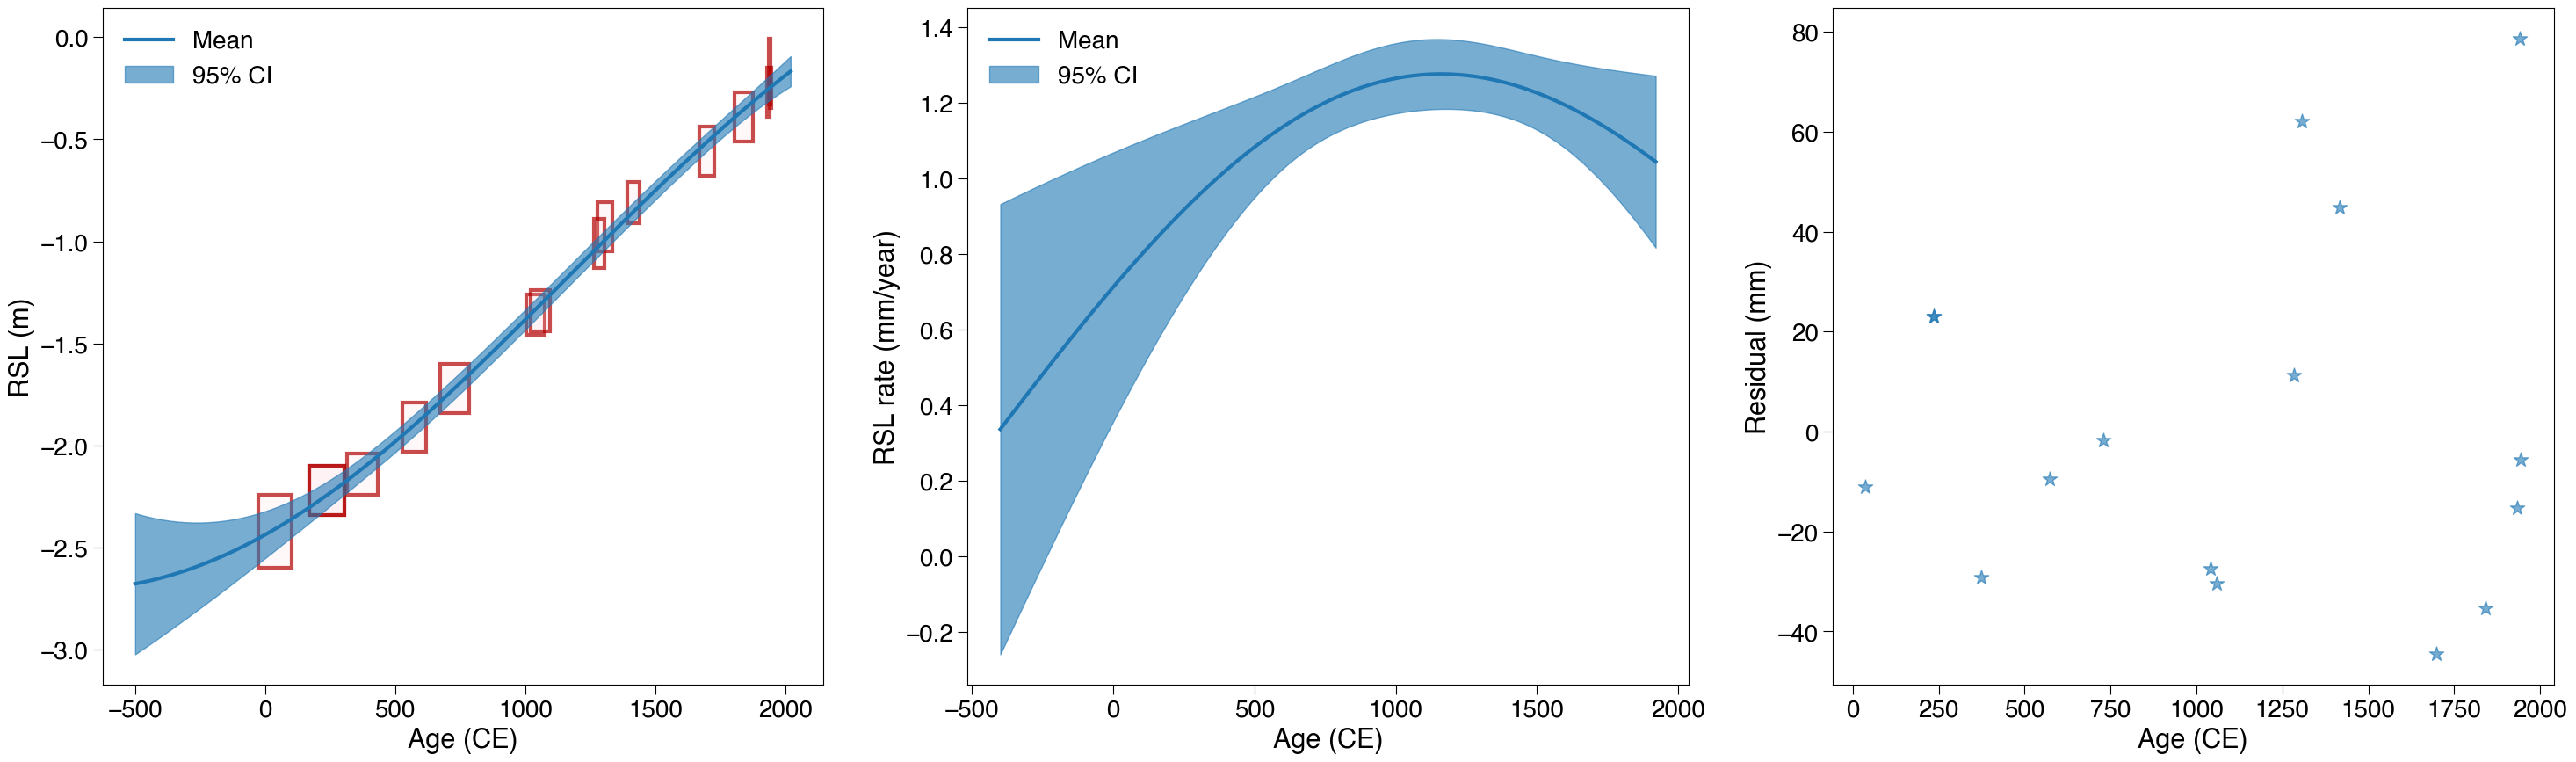

In [123]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean, y_var = gpr(x_test.double(), full_cov=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(NNC_X[random_index],NNC_y[random_index],NNC_x_sigma[random_index],NNC_y_sigma[random_index],x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)

**Fully Bayesian Analysis:**

In [124]:
#------------------Fully Bayesian GP------------------
# calculate computational time
torch.manual_seed(30)

st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
#set prior distributions for RBF hyperparameters
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(10000.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_EIV(NNC_X[random_index], NNC_y[random_index],x_noise =  NNC_x_sigma[random_index]**2,kernel=RBF_kernel,noise=torch.tensor(NNC_y_sigma[random_index]**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
#if this is too low, slightly decrease the target_accept_prob and restart again! 
# default target_accept_prob is 0.8 
mcmc = PSTHM.opti.NUTS_mcmc(gpr,num_samples=2000,warmup_steps=200,print_stats=True)

#calulate log likelihood of the model prediction
#change kernel value to posterior mean 
RBF_kernel.variance = mcmc.get_samples()['kernel.variance'].mean()
RBF_kernel.variance = mcmc.get_samples()['kernel.lengthscale'].mean()

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


Sample: 100%|██████████| 2200/2200 [00:37, 58.77it/s, step size=5.33e-01, acc. prob=0.879] 


-----kernel.lengthscale: 6888.60 +/ 4374.18 (2sd)-----
Gelman-Rubin statistic for kernel.lengthscale: 1.00
Effective sample size for kernel.lengthscale: 1421.12
-----kernel.variance: 213.18 +/ 483.60 (2sd)-----
Gelman-Rubin statistic for kernel.variance: 1.00
Effective sample size for kernel.variance: 758.84
Execution time: 37.574 s


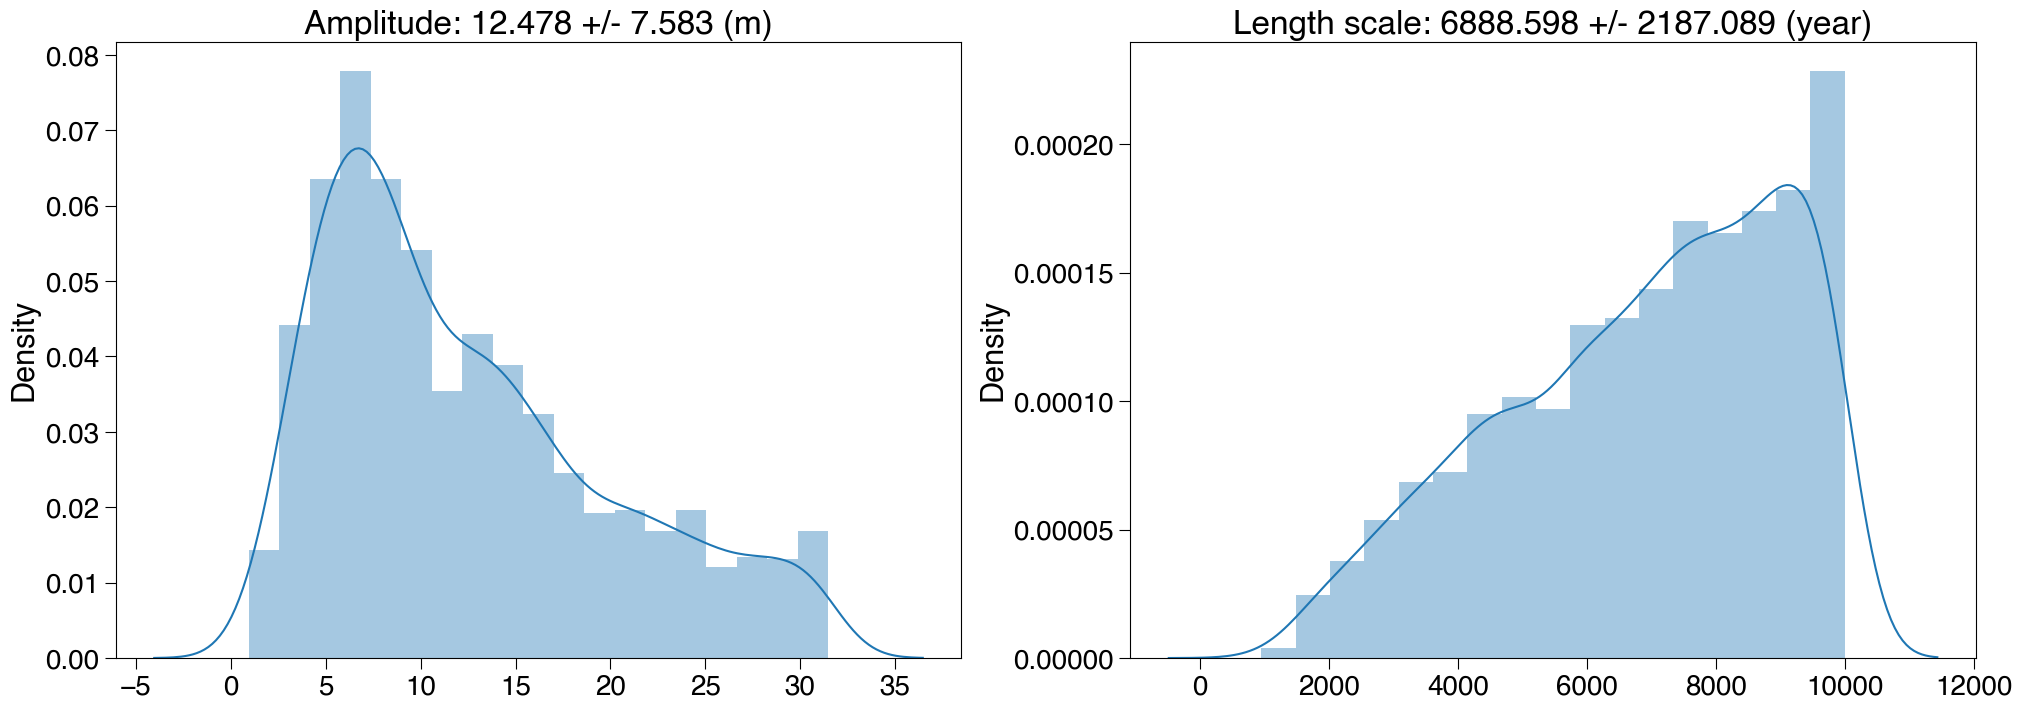

In [125]:
mcmc_variance = mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(mcmc_variance**0.5)
# plt.vlines(track_list['variance'].iloc[-1]**0.5,0,0.20,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.subplot(122)
sns.distplot(mcmc_lengthscale)
# plt.vlines(track_list['lengthscale'].iloc[-1],0,0.002,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} (year)'.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)));


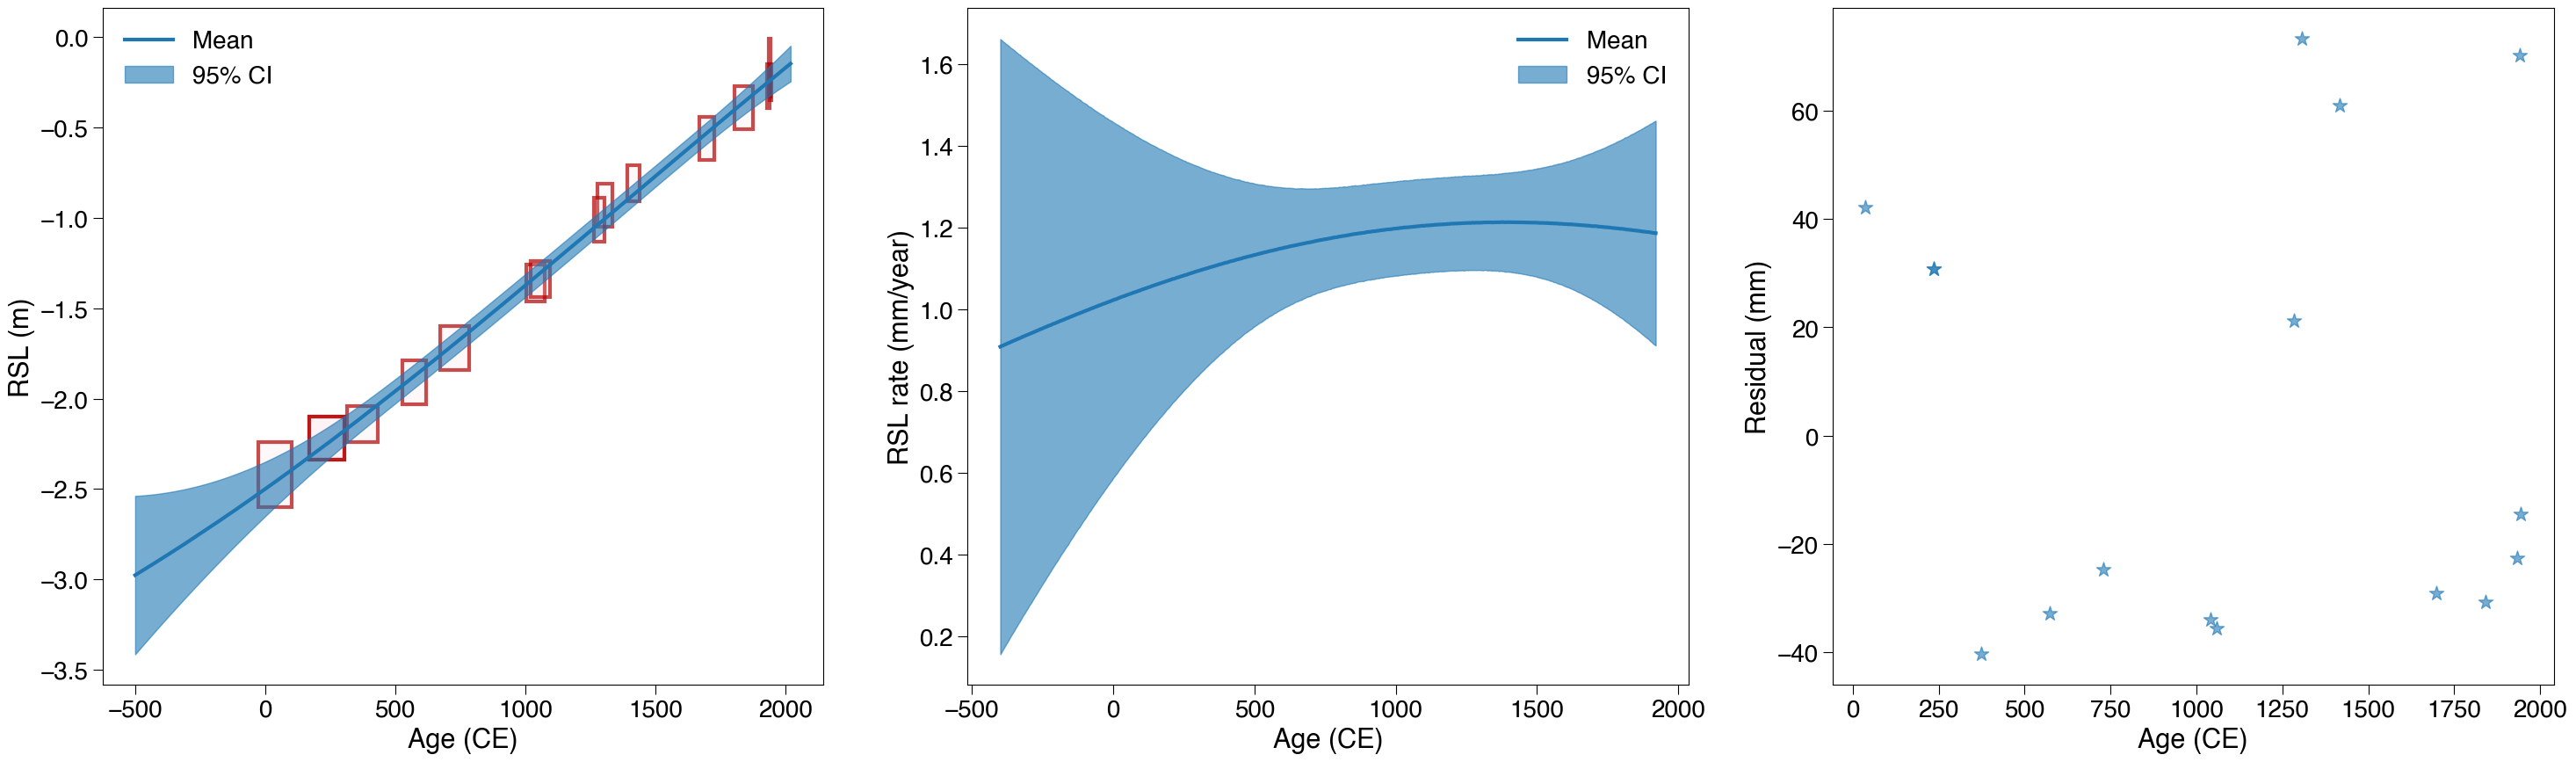

In [126]:
#get posterior predictive distributions
x_test = torch.arange(-500,2025,5.).double()

post_x = mcmc.get_samples()['xerr'].detach().numpy()+NNC_X[random_index][None,:].detach().numpy()
post_y = np.random.normal(NNC_y[random_index],NNC_y_sigma[random_index],[2000,len(NNC_y_sigma[random_index])])
full_bayes_y = np.zeros([20000,len(x_test)])

#calculate posterior prediction
for i in range(2000):
    gpr.X = torch.tensor(post_x[i])
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.lengthscale = mcmc.get_samples()['kernel.lengthscale'][i]
    gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][i]
    test_mean,test_cov = gpr(x_test,full_cov=True)
    test_cov += (torch.ones(len(test_cov))*1e-5).diag()

    random_sample = dist.MultivariateNormal(test_mean,test_cov).sample((10,))
    full_bayes_y[i*10:(i+1)*10] = random_sample.detach().numpy()
    
full_bayes_mean = np.mean(full_bayes_y,axis=0)
full_bayes_mean_cov = np.cov(full_bayes_y.T)

full_bayes_sd = np.std(full_bayes_y,axis=0)

full_bayes_x_test = torch.arange(-500,2025,5.)

full_bayes_rsl_time,full_bayes_rate,full_bayes_rate_sd = PSTHM.post.cal_rate_var(full_bayes_x_test.detach().numpy(),full_bayes_mean_cov,full_bayes_mean)

axes = PSTHM.plotting.plot_tem_regression(NNC_X[random_index],NNC_y[random_index],NNC_x_sigma[random_index],NNC_y_sigma[random_index],full_bayes_x_test,full_bayes_mean,full_bayes_sd,
                          full_bayes_rsl_time,full_bayes_rate,full_bayes_rate_sd)

**Variational Bayesian Analysis:**

Considering the computational expense required to perform MCMC in fully Bayesian analysis, and the limitations of Empirical Bayesian methods that fail to account for the uncertainty of hyperparameters, PaleoSTeHM also supports variational Bayesian analysis, which emerges as an efficient intermediary. 

  0%|          | 0/500 [00:00<?, ?it/s]

Execution time: 1.371 s


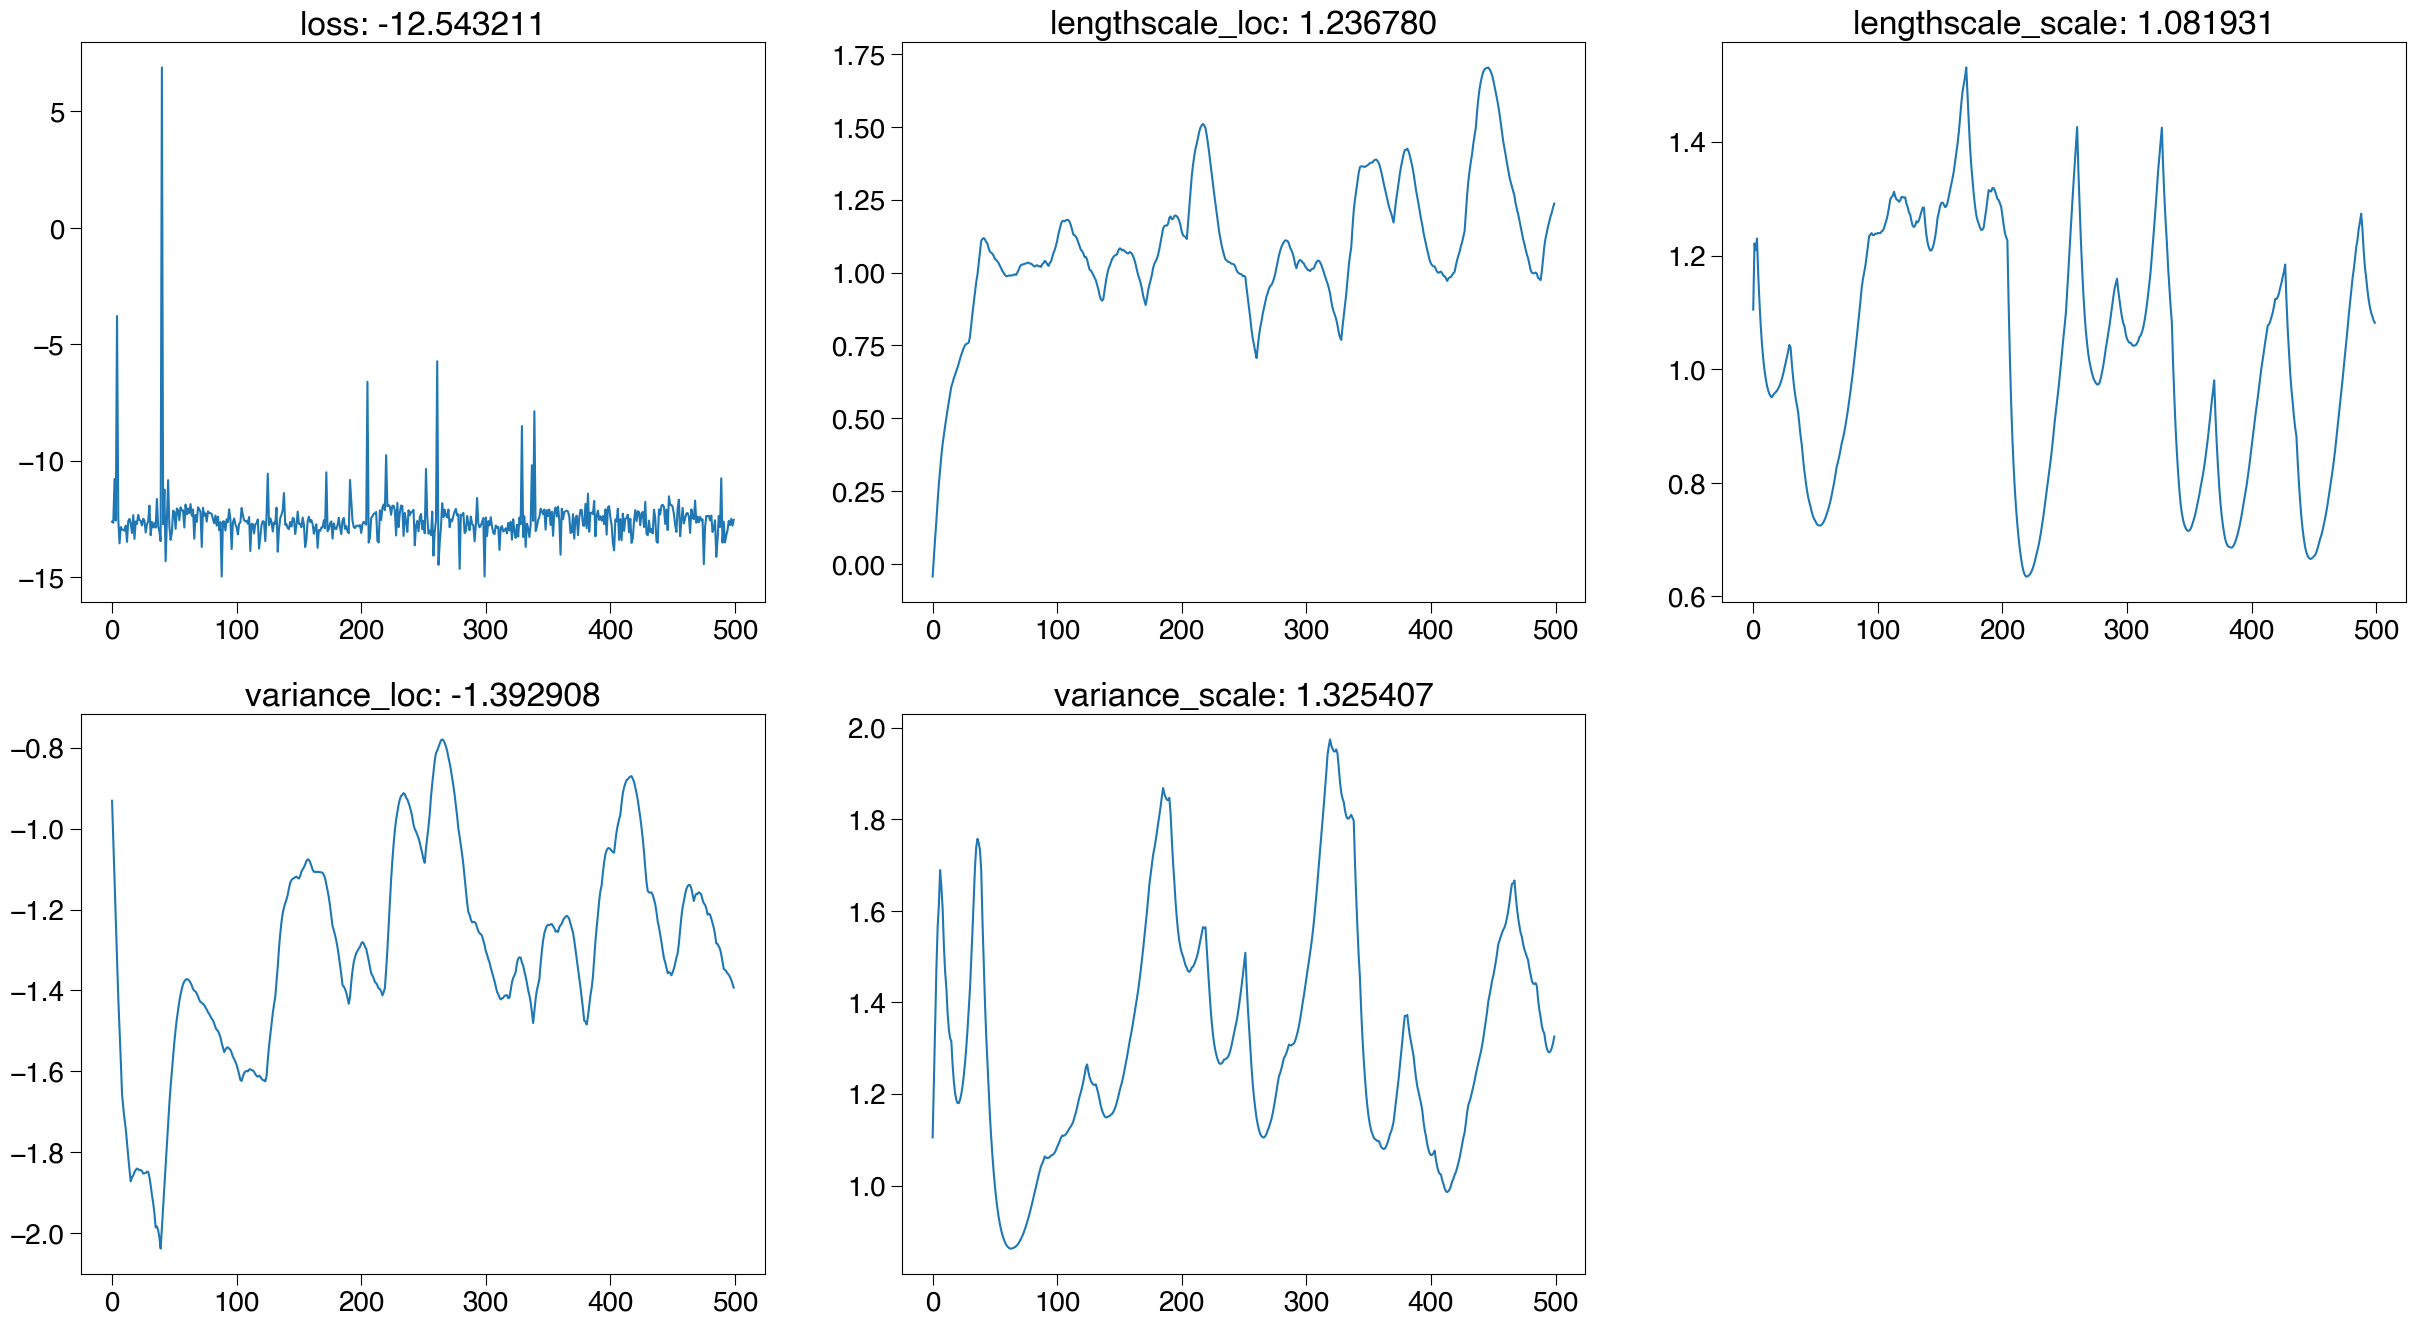

In [127]:
#------------------Empirical Bayes------------------
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.),geo=False)
#set prior distribution for kernels
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
RBF_kernel.autoguide("variance",dist.Normal) 
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(10000.)))
RBF_kernel.autoguide("lengthscale",dist.Normal)

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(NNC_X[random_index], NNC_y[random_index], RBF_kernel,noise=torch.tensor(NNC_y_sigma[random_index]**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 500
gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,NNC_x_sigma[random_index],lr=0.1,num_iteration=500)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))
axes = PSTHM.plotting.plot_track_list(track_list)


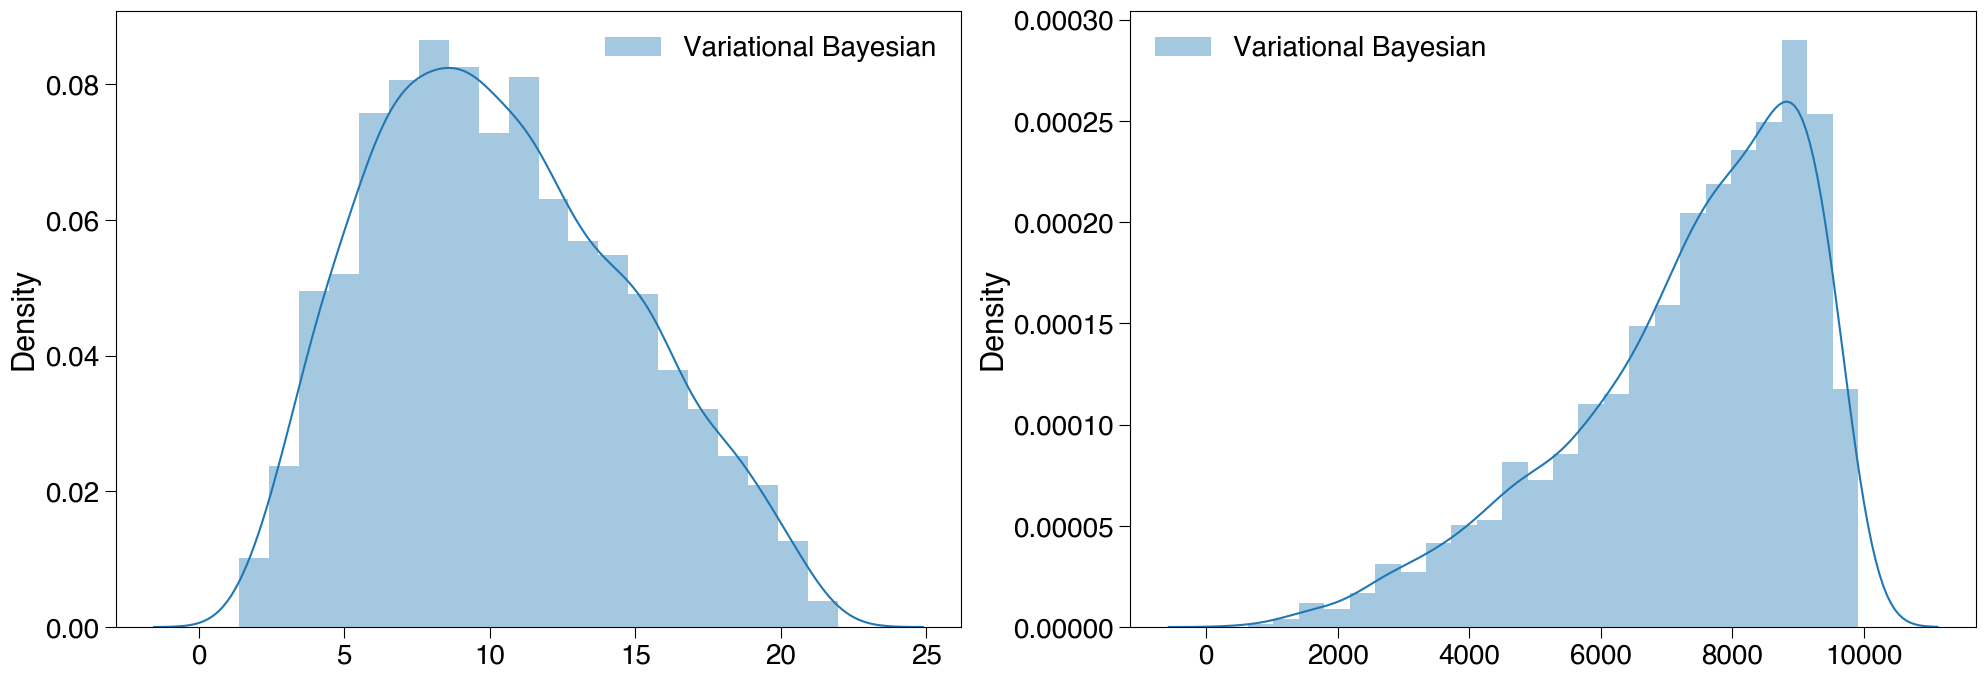

In [128]:
variational_variance = np.zeros(2000)
variational_lengthscale = np.zeros(2000)

for i in range(2000):
    variational_variance[i] = RBF_kernel.variance.detach().numpy()
    variational_lengthscale[i] = RBF_kernel.lengthscale.detach().numpy()

plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(variational_variance**0.5,label='Variational Bayesian')
plt.legend()
plt.subplot(122)
sns.distplot(variational_lengthscale,label='Variational Bayesian')
plt.legend();

## 

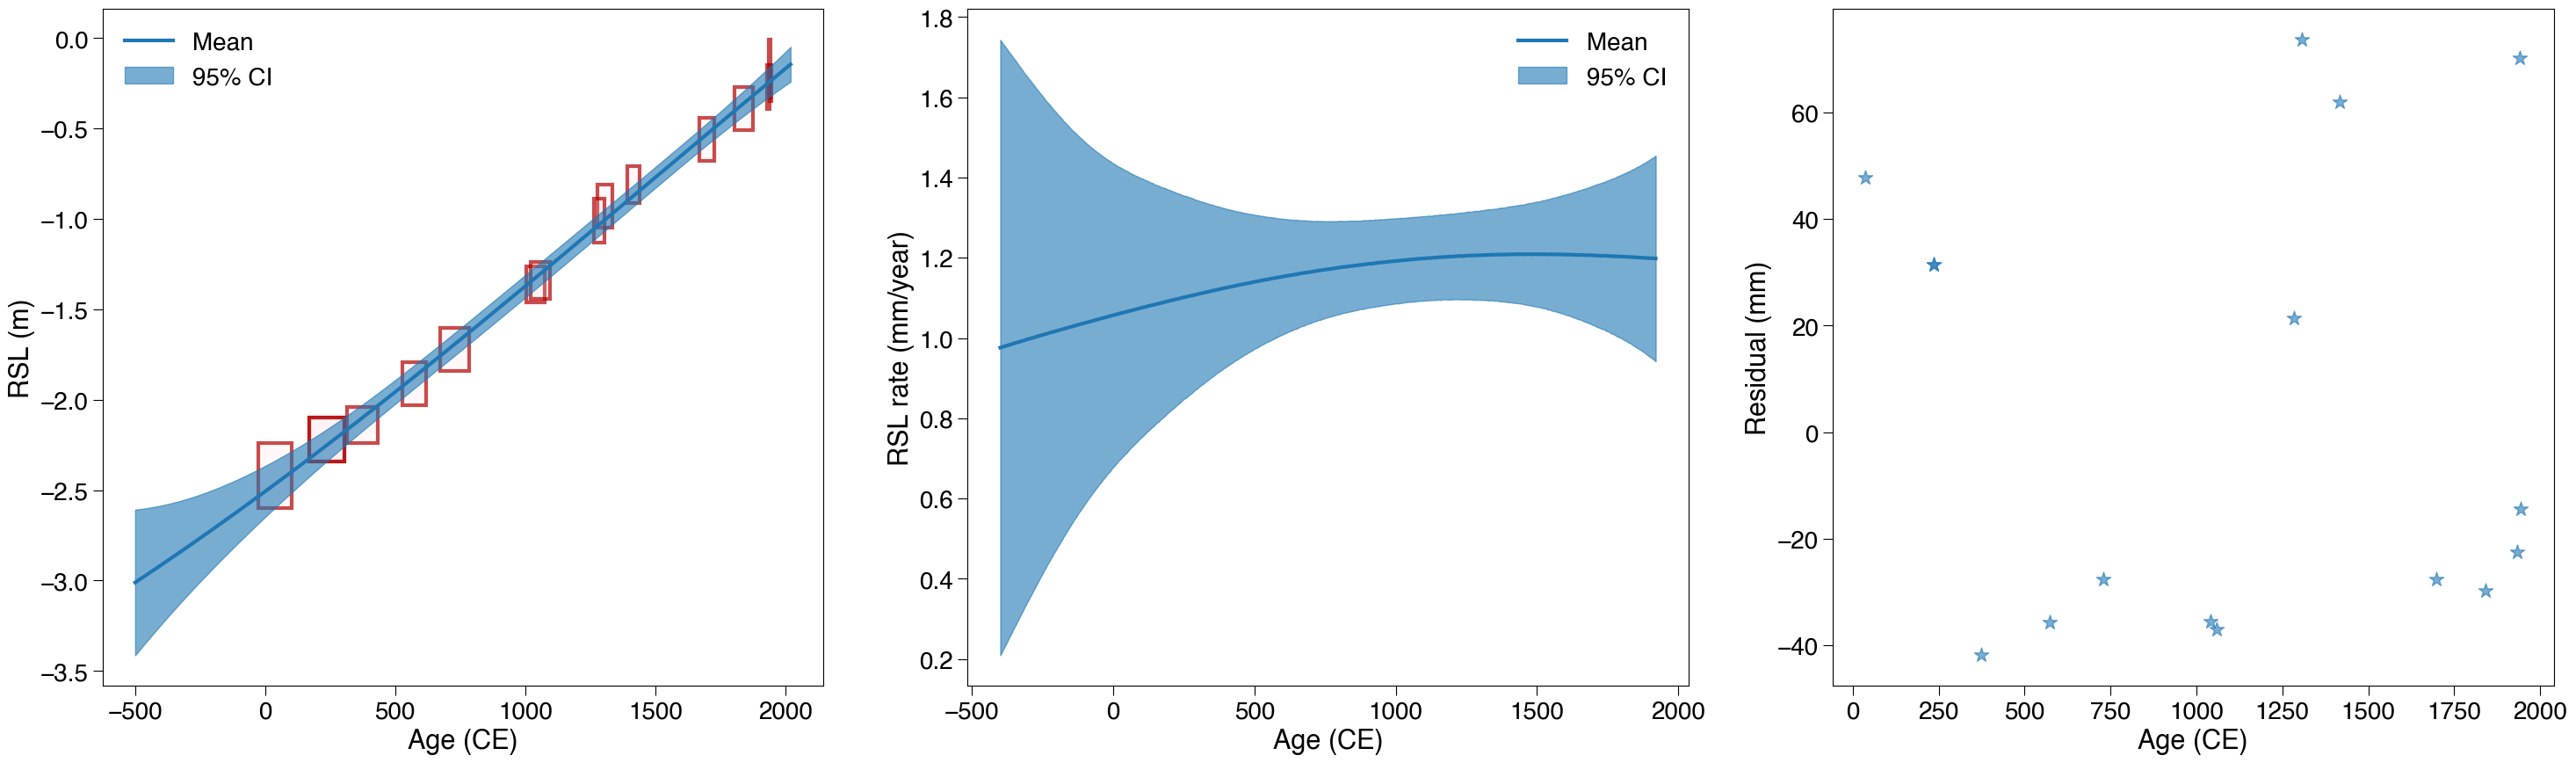

In [129]:
vari_bayes_y = np.zeros([20000,len(x_test)])
vari_bayes_cov = np.zeros([20000,len(x_test),len(x_test)])

#calculate posterior prediction
for i in range(2000):
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.lengthscale =variational_lengthscale[i]
    gpr.kernel.variance =variational_variance[i]
    test_mean,test_cov = gpr(x_test,full_cov=True)
    test_cov += (torch.ones(len(test_cov))*1e-5).diag()
    random_sample = dist.MultivariateNormal(test_mean,test_cov).sample((10,))
    vari_bayes_y[i*10:(i+1)*10] = random_sample.detach().numpy()

vari_bayes_mean = np.mean(vari_bayes_y,axis=0)
vari_bayes_mean_cov = np.cov(vari_bayes_y.T)
vari_bayes_sd = np.std(vari_bayes_y,axis=0)

vari_bayes_rsl_time,vari_bayes_rate,vari_bayes_rate_sd = PSTHM.post.cal_rate_var(full_bayes_x_test.detach().numpy(),vari_bayes_mean_cov,vari_bayes_mean)

axes = PSTHM.plotting.plot_tem_regression(NNC_X[random_index],NNC_y[random_index],NNC_x_sigma[random_index],NNC_y_sigma[random_index],full_bayes_x_test,vari_bayes_mean,vari_bayes_sd,
                          full_bayes_rsl_time,vari_bayes_rate,vari_bayes_rate_sd)

### Comparing three analysis choices

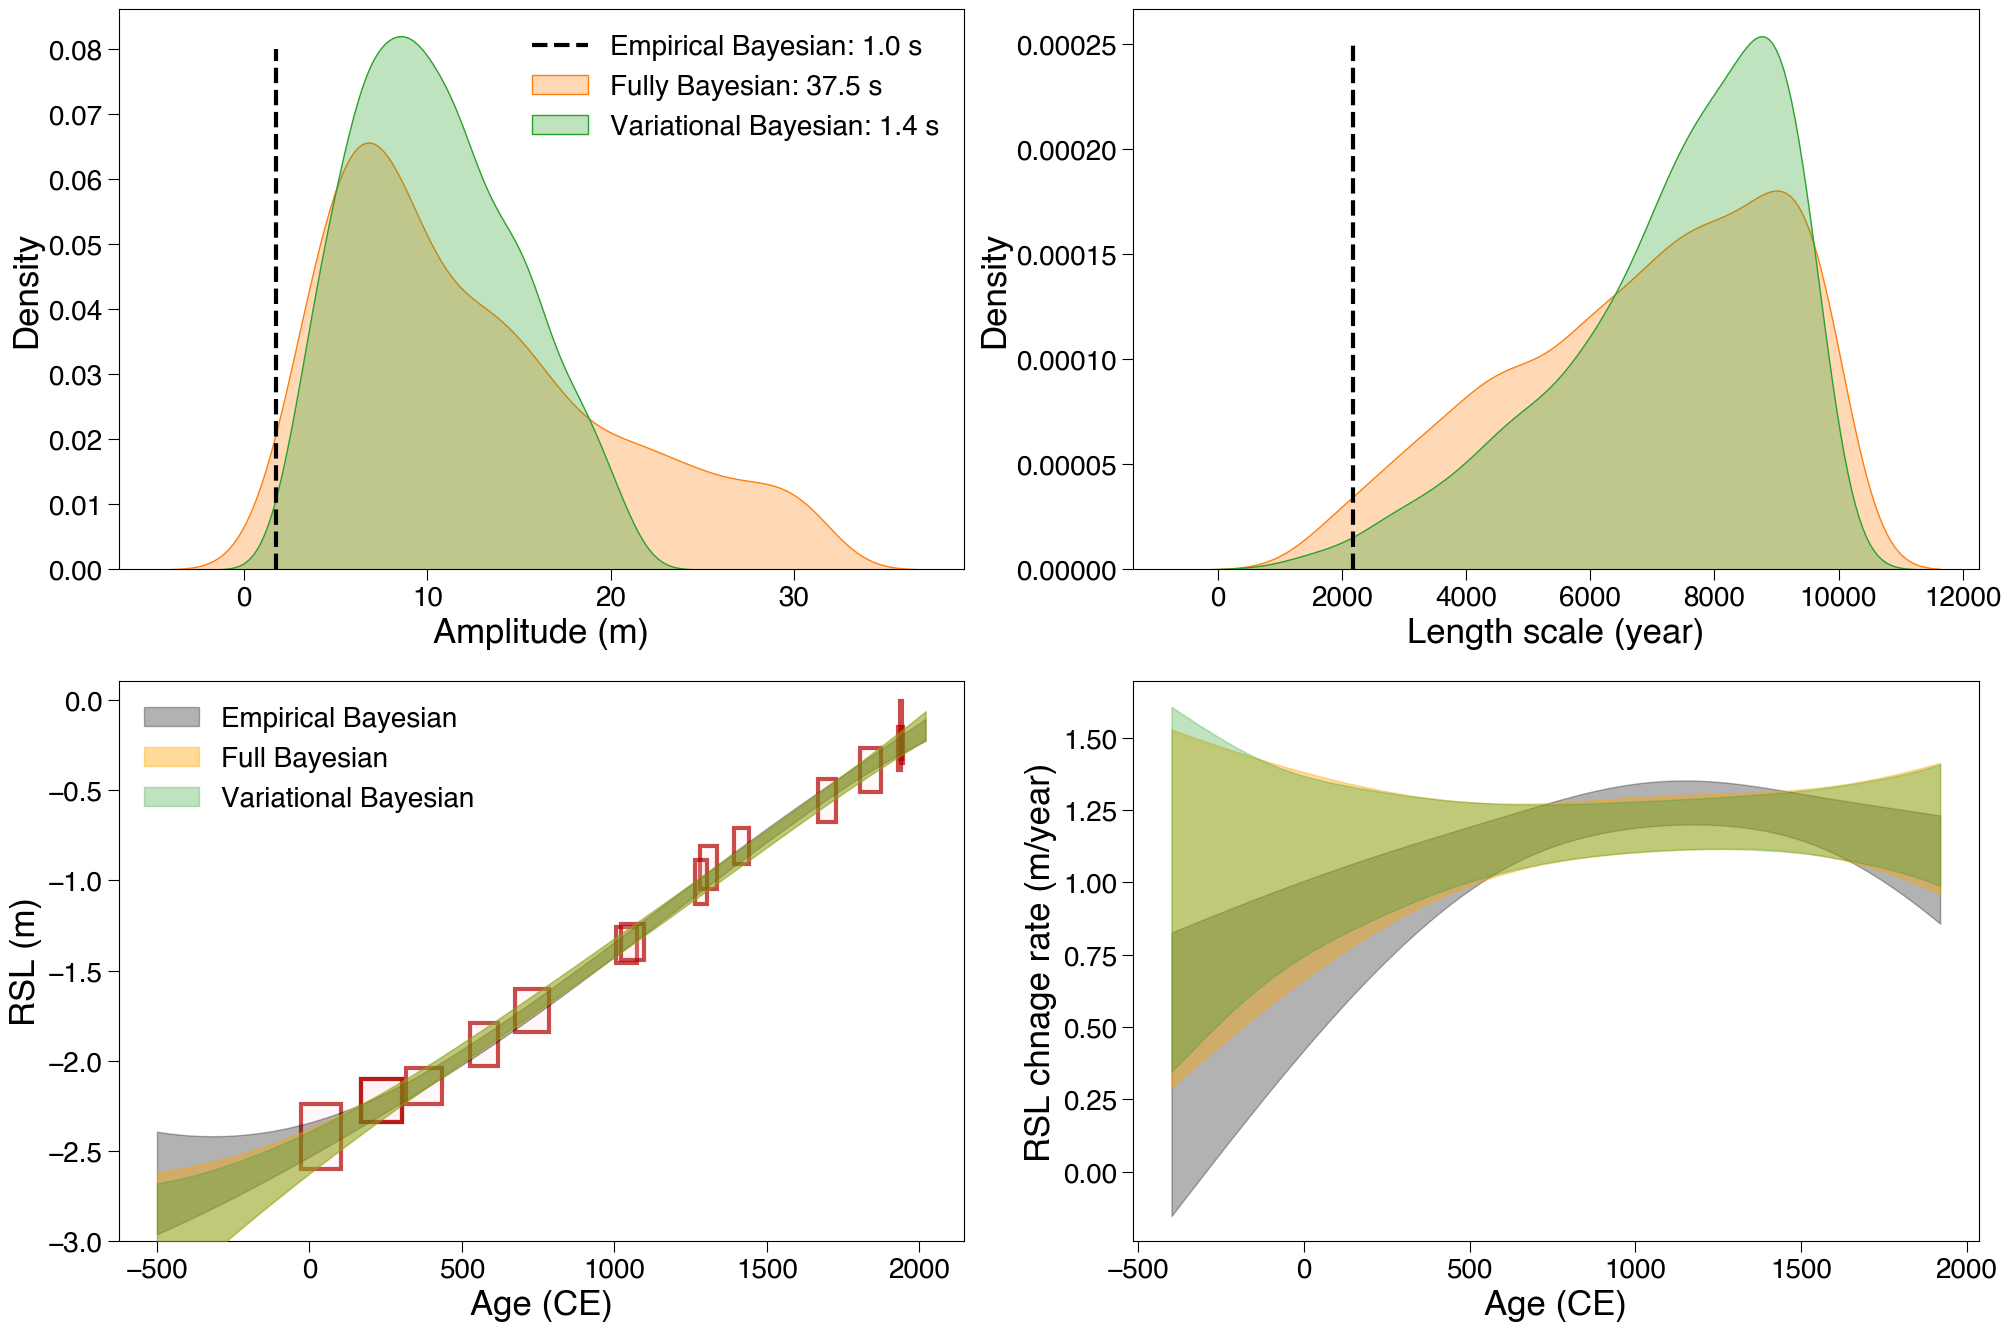

In [142]:
plt.figure(figsize=(24,16))
plt.subplot(221)
plt.vlines(emp_track_list['variance'].iloc[-1]**0.5,0,0.08,linestyle='--',label='Empirical Bayesian: 1.0 s',linewidth=3,color='k')
sns.kdeplot(mcmc_variance**0.5,label='Fully Bayesian: 37.5 s',color='C1',fill=True,alpha=0.3,bw_method=0.25)
sns.kdeplot(variational_variance**0.5,label='Variational Bayesian: 1.4 s',color='C2',fill=True,alpha=0.3,bw_method=0.25)
plt.xlabel('Amplitude (m)',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.legend()
plt.subplot(222)
sns.kdeplot(mcmc_lengthscale,label='Fully Bayesian',color='C1',fill=True,alpha=0.3,bw_method=0.25)
sns.kdeplot(variational_lengthscale,label='Variational Bayesian',color='C2',fill=True,alpha=0.3,bw_method=0.25)
plt.vlines(emp_track_list['lengthscale'].iloc[-1],0,0.00025,linestyle='--',label='Empirical Bayesian',linewidth=3,color='k')
plt.xlabel('Length scale (year)',fontsize=25)
plt.ylabel('Density',fontsize=25)
ax = plt.subplot(223)
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X[random_index],NNC_y[random_index],NNC_x_sigma[random_index]*2,NNC_y_sigma[random_index]*2,ax=ax,CE=True)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean - 1.645 * sd).detach().numpy(),
            (y_mean + 1.645 * sd).detach().numpy(),
            color="k",
            alpha=0.3,zorder=10,label='Empirical Bayesian')
ax.fill_between(
            full_bayes_x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (full_bayes_mean - 1.645 * full_bayes_sd),
            (full_bayes_mean + 1.645 * full_bayes_sd),
            color="orange",
            alpha=0.4,zorder=10,label='Full Bayesian')
ax.fill_between(
            full_bayes_x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (vari_bayes_mean - 1.645 * vari_bayes_sd),
            (vari_bayes_mean + 1.645 * vari_bayes_sd),
            color="C2",
            alpha=0.3,zorder=10,label='Variational Bayesian')
# plt.plot(x_test.detach().numpy(),y_mean.detach().numpy(),linewidth=2,color='C0')
# plt.plot(full_bayes_x_test.detach().numpy(),full_bayes_mean,linewidth=2,color='orange')
# plt.plot(full_bayes_x_test.detach().numpy(),vari_bayes_mean,linewidth=2,color='C2')
ax.legend(loc=2)
plt.xlabel('Age (CE)',fontsize=25)
plt.ylabel('RSL (m)',fontsize=25)
plt.ylim(-3,0.1)
ax = plt.subplot(224)

ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate - 1.645 * rsl_rate_sd)*1000,
            (rsl_rate + 1.645 * rsl_rate_sd)*1000,
            color="k",
            alpha=0.3,zorder=10,label='Empirical Bayesian')

ax.fill_between(
            full_bayes_rsl_time,  # plot the two-sigma uncertainty about the mean
            (full_bayes_rate - 1.645 * full_bayes_rate_sd)*1000,
            (full_bayes_rate + 1.645 * full_bayes_rate_sd)*1000,
            color="orange",
            alpha=0.4,zorder=10,label='Full Bayesian')
ax.fill_between(
            vari_bayes_rsl_time,  # plot the two-sigma uncertainty about the mean
            (vari_bayes_rate - 1.645 * vari_bayes_rate_sd)*1000,
            (vari_bayes_rate + 1.645* vari_bayes_rate_sd)*1000,
            color="C2",
            alpha=0.3,zorder=10,label='Variational Bayesian'
)
# plt.plot(rsl_time,rsl_rate*1000,linewidth=2,color='C0')

# plt.plot(full_bayes_rsl_time,full_bayes_rate*1000,linewidth=2,color='orange')
# plt.plot(vari_bayes_rsl_time,vari_bayes_rate*1000,linewidth=2,color='C2')

plt.xlabel('Age (CE)',fontsize=25)
plt.ylabel('RSL chnage rate (m/year)',fontsize=25)

plt.savefig('Analysis_choice.pdf',dpi=300);

You can see that, for this site, the empirical, fully and variational Bayesian analysis actually yields quite similar results, especially for locations where we have data. But for some sea-level problems, empirical Bayesian analysis may significantly undereastimate the underlying uncertainties associated with hyperparameters, you can check [Piecuch et al., (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012506) for details. And for applications where we have many data points, variaitonal Bayesian analysis could be a good intermediary.

Ok, you have finished the introduction series for Bayesian hierachical modelling now, I hope you enjoyed it so far! For the next tutorial seires, we will give a detailed explanation on Gaussian Process, including (1) kernel introduction; (2) alternative kernel choices; (3) multiple kernels; (4) how to deal with temporal uncertainty and so on, see you there! 

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.